In [1]:
# Import libraries

# Usual libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import string
import random

# NLTK
import nltk
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Assigning variables
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
stop_words = stopwords.words('english')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as gbm
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

# Doc/Word Vectors
from gensim.models.fasttext import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary

# LDA and LSI Models
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models import LsiModel, CoherenceModel
from gensim.models import TfidfModel
from gensim.models import LdaModel, LdaMulticore
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Spacy
import spacy
from spacy.lang.en.examples import sentences
from spacy import displacy
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')
stopwords_nlp = nlp.Defaults.stop_words

# LIME and SHAP
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import shap

# Set seed
np.random.seed(123)

In [2]:
# Import datasets
df = pd.read_csv(r'C:\Users\Scott\Box\Shyam\01_Shyam_Personal\Text Mining\Twitter\IranUnrest_YoutubeFinalData.csv')
df.head()

,Name,Comment,Time,Likes,Reply Count
0,Guardian News,Iranian schoolgirl ‘beaten to death for refusi...,2022-10-19T09:42:51Z,8.0,2.0
1,silent majority,One more reason why IS lam not compatible for...,2022-10-19T21:11:37Z,NaN,NaN
2,Good,Free Iran,2022-10-22T22:05:44Z,0.0,0.0
3,Spencer Brown,"This abhorrent, evil, archaic regime is killin...",2022-10-22T16:33:27Z,0.0,0.0
4,sunita thind,I have no words. Grateful to have freedoms 🇬🇧h...,2022-10-22T08:54:14Z,1.0,0.0


## Data Cleaning

In [3]:
# Check for duplicates and drop them
print(len(df))
df.drop_duplicates(['Comment'])
print(len(df))

14988
14988


In [4]:
# Loop through the column and clean the data

new_text = []

for text in df['Comment']:
    text = re.sub(r'[!"#$%&()*+,-./:;<=>?[\]^_`{|}~]', ' ', text).lower()               # Remove punctuation and make the letters lowercase
        
    words = nltk.tokenize.word_tokenize(text)                                           # Tokenize the text
    words = [w for w in words if w.isalpha()]                                           # Ensure the data is alphabets (remove numbers)
    words = [w for w in words if len(w)>1 and w not in stopwords.words('english')]      # Remove words that are less than 2 characters and stop words as well
        
    words = [lemmatizer.lemmatize(w) for w in words]                                    # Lemmatize the words
    new_text.append(' '.join(words))

# Make a copy of the original dataframe and add the cleaned text into a new column
df['cleaned_tweet'] = new_text
df.head()

,Name,Comment,Time,Likes,Reply Count,cleaned_tweet
0,Guardian News,Iranian schoolgirl ‘beaten to death for refusi...,2022-10-19T09:42:51Z,8.0,2.0,iranian schoolgirl beaten death refusing sing ...
1,silent majority,One more reason why IS lam not compatible for...,2022-10-19T21:11:37Z,NaN,NaN,one reason lam compatible western democracy br...
2,Good,Free Iran,2022-10-22T22:05:44Z,0.0,0.0,free iran
3,Spencer Brown,"This abhorrent, evil, archaic regime is killin...",2022-10-22T16:33:27Z,0.0,0.0,abhorrent evil archaic regime killing woman sc...
4,sunita thind,I have no words. Grateful to have freedoms 🇬🇧h...,2022-10-22T08:54:14Z,1.0,0.0,word grateful freedom many beautiful innocent ...


## EDA

In [5]:
# Count the number of likes a post has received
df['Likes'].value_counts().nlargest(10)

0.0     7736
1.0     1782
2.0      442
3.0      157
4.0      102
6.0       68
5.0       63
8.0       36
7.0       32
10.0      28
Name: Likes, dtype: int64

In [6]:
df['Reply Count'].value_counts().nlargest(10)

0.0    9591
1.0     726
2.0     203
3.0      96
4.0      45
7.0      24
6.0      24
5.0      22
9.0      18
8.0      12
Name: Reply Count, dtype: int64

## Sentiment Analysis

In [7]:
# Creating a copy of the dataframe
df_sentiment = df.copy()

In [8]:
df_sentiment['compound'] = df_sentiment['Comment'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['compound'])
df_sentiment['positive'] = df_sentiment['Comment'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['pos'])
df_sentiment['negative'] = df_sentiment['Comment'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['neg'])
df_sentiment.head()

,Name,Comment,Time,Likes,Reply Count,cleaned_tweet,compound,positive,negative
0,Guardian News,Iranian schoolgirl ‘beaten to death for refusi...,2022-10-19T09:42:51Z,8.0,2.0,iranian schoolgirl beaten death refusing sing ...,-0.7650,0.000,0.375
1,silent majority,One more reason why IS lam not compatible for...,2022-10-19T21:11:37Z,NaN,NaN,one reason lam compatible western democracy br...,0.5423,0.156,0.000
2,Good,Free Iran,2022-10-22T22:05:44Z,0.0,0.0,free iran,0.5106,0.767,0.000
3,Spencer Brown,"This abhorrent, evil, archaic regime is killin...",2022-10-22T16:33:27Z,0.0,0.0,abhorrent evil archaic regime killing woman sc...,-0.9601,0.000,0.634
4,sunita thind,I have no words. Grateful to have freedoms 🇬🇧h...,2022-10-22T08:54:14Z,1.0,0.0,word grateful freedom many beautiful innocent ...,0.7146,0.414,0.209


In [9]:
print('Compound:', df_sentiment['compound'].mean())
print('Positive:', df_sentiment['positive'].mean())
print('Negative:', df_sentiment['negative'].mean())

Compound: -0.012537630104083035
Positive: 0.1328261942887642
Negative: 0.12094462236455907


Text(0.5, 1.0, 'Polarity Score Distribution')

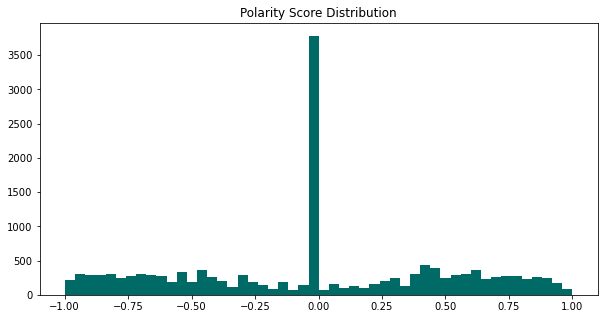

In [10]:
plt.figure(figsize=(10,5))
plt.hist(df_sentiment['compound'], bins = 50, color = '#006B66')
# plt.ylim(0,200)
plt.title('Polarity Score Distribution')

In [11]:
# Trying Spacy
# lets create a new column with the sentiment of the comment

df_sentiment['sentiment'] = df_sentiment['Comment'].apply(lambda x: nlp(x)._.blob.polarity)

In [12]:
print('Text Blob Polartiy Score:', df_sentiment['sentiment'].mean())

Text Blob Polartiy Score: 0.04845205622708246


Text(0.5, 1.0, 'Polarity Score Distribution')

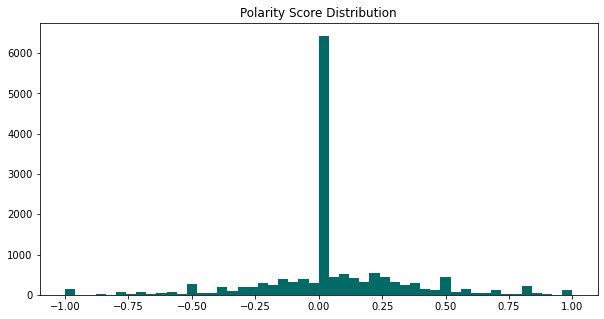

In [13]:
plt.figure(figsize=(10,5))
plt.hist(df_sentiment['sentiment'], bins = 50, color = '#006B66')
# plt.ylim(0,200)
plt.title('Polarity Score Distribution')

## Speech Scoring Prep

In [14]:
def clean_text(text):
    # make everything lowercase
    text = text.lower()
    # only lowercase letters no numbers or special characters
    text = re.sub(r'[^a-z]', ' ', text)
    
    # only accept nouns, pronouns and entities
    doc = nlp(text)
    text = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN', 'PRON', 'ADJ'] and len(token.text) > 3]
    return text

In [15]:
df['title'] = df['Comment'].apply(clean_text)
df.head()

,Name,Comment,Time,Likes,Reply Count,cleaned_tweet,title
0,Guardian News,Iranian schoolgirl ‘beaten to death for refusi...,2022-10-19T09:42:51Z,8.0,2.0,iranian schoolgirl beaten death refusing sing ...,"[iranian, schoolgirl, death, regime, anthem, h..."
1,silent majority,One more reason why IS lam not compatible for...,2022-10-19T21:11:37Z,NaN,NaN,one reason lam compatible western democracy br...,"[more, reason, compatible, western, democracy,..."
2,Good,Free Iran,2022-10-22T22:05:44Z,0.0,0.0,free iran,"[free, iran]"
3,Spencer Brown,"This abhorrent, evil, archaic regime is killin...",2022-10-22T16:33:27Z,0.0,0.0,abhorrent evil archaic regime killing woman sc...,"[abhorrent, evil, archaic, regime, women, scarf]"
4,sunita thind,I have no words. Grateful to have freedoms 🇬🇧h...,2022-10-22T08:54:14Z,1.0,0.0,word grateful freedom many beautiful innocent ...,"[words, grateful, freedoms, many, beautiful, i..."


In [16]:
# lets create a new column with the length of the comment
df['length'] = df['title'].apply(lambda x: len(x))
df.head()

,Name,Comment,Time,Likes,Reply Count,cleaned_tweet,title,length
0,Guardian News,Iranian schoolgirl ‘beaten to death for refusi...,2022-10-19T09:42:51Z,8.0,2.0,iranian schoolgirl beaten death refusing sing ...,"[iranian, schoolgirl, death, regime, anthem, h...",24
1,silent majority,One more reason why IS lam not compatible for...,2022-10-19T21:11:37Z,NaN,NaN,one reason lam compatible western democracy br...,"[more, reason, compatible, western, democracy,...",7
2,Good,Free Iran,2022-10-22T22:05:44Z,0.0,0.0,free iran,"[free, iran]",2
3,Spencer Brown,"This abhorrent, evil, archaic regime is killin...",2022-10-22T16:33:27Z,0.0,0.0,abhorrent evil archaic regime killing woman sc...,"[abhorrent, evil, archaic, regime, women, scarf]",6
4,sunita thind,I have no words. Grateful to have freedoms 🇬🇧h...,2022-10-22T08:54:14Z,1.0,0.0,word grateful freedom many beautiful innocent ...,"[words, grateful, freedoms, many, beautiful, i...",7


In [17]:
all_comments = ' '.join(df['title'].apply(lambda x: ' '.join(x)))
len(all_comments)

1018378

In [18]:
# check how many unique words are in the comments
total_unique = len(set(all_comments.split()))

# average unique words per comment
unique_words_by_comment = len(set(all_comments.split())) / len(all_comments.split())

In [19]:
# check how many total words are in the comments
total_words = len(all_comments.split())
total_words

143883

In [20]:
# check how many average words are in the comments
average_words_by_comment = len(all_comments.split()) / len(df)
average_words_by_comment

9.599879903923139

## Hate Speech

##### Scraped data from https://en.wikipedia.org/wiki/List_of_ethnic_slurs

In [23]:
# Importing data scraped form Wikipedia which contains a list of slurs
df_hate = pd.read_csv(r'C:\Users\Scott\Box\Shyam\01_Shyam_Personal\Text Mining\Twitter\ethnic_slurs.csv')

df_hate.head()

,Term,Location,Target,Meaning
0,abbie abe abie,north america,jewish men,originated before the 1950s from the proper na...
1,abc,east asia,americanborn chinese han or other chinese incl...,the term implies an otherness or lack of conne...
2,abcd,south asians in the us,americanborn confused desi indian americans or...,used chiefly by south asian immigrants to impl...
3,abidabeed plural,middle east and north africa,black african people,arabic for slave associated with the arab slav...
4,aboabbo,australia,australian aboriginal person,originally this was simply an informal term fo...


In [24]:
# make a set of all unique words in Term 
hate_terms = set()
for term in df_hate['Term']:
    for word in term.split():
        if len(word) < 4:
            continue
        hate_terms.add(word)

In [25]:
# check if the comments contain any of the hate words
hate_score = []
for comment in df['title']:
    hate_count = 0
    for content in comment:
        for word in hate_terms:
            if word in content:
                hate_count += 1

    hate_score.append(hate_count)

# add the hate score to the dataframe
df['hate_score'] = hate_score
df.head(2)

,Name,Comment,Time,Likes,Reply Count,cleaned_tweet,title,length,hate_score
0,Guardian News,Iranian schoolgirl ‘beaten to death for refusi...,2022-10-19T09:42:51Z,8.0,2.0,iranian schoolgirl beaten death refusing sing ...,"[iranian, schoolgirl, death, regime, anthem, h...",24,3
1,silent majority,One more reason why IS lam not compatible for...,2022-10-19T21:11:37Z,NaN,NaN,one reason lam compatible western democracy br...,"[more, reason, compatible, western, democracy,...",7,1


In [26]:
# get the top 5 rows with the highest hate score
df.sort_values(by='hate_score', ascending=False).head(2)

# Get the percentage of hate score devided by the total length of the comment
df['hate_score_percentage'] = df['hate_score'] / df['length'] * 100

# get the sum of the total hate score / sum of the total length of the comment * 100
percentage_total_hate = df['hate_score'].sum() / df['length'].sum() * 100
print(f"hate speech score: {percentage_total_hate:.2f}%")

hate speech score: 3.87%


## Offensive Speech

##### Scraped data from https://en.wiktionary.org/wiki/Category:English_swear_words

In [27]:
# Import offensive words list data
df_offensive = pd.read_csv(r'C:\Users\Scott\Box\Shyam\01_Shyam_Personal\Text Mining\Twitter\offensive_words.csv')
df_offensive.head()

,Offensive_Words
0,arse
1,arsehead
2,arsehole
3,ass
4,asshole


In [49]:
# make a set of all unique words in Term 
offensive_terms = set()
for term in df_offensive['Offensive_Words']:
    for word in term.split():
        if len(word) < 2:
            continue
        offensive_terms.add(word)

In [50]:
# check if the comments contain any of the offensive words
offensive_score = []
for comment in df['title']:
    offensive_count = 0
    for content in comment:
        for word in offensive_terms:
            if word in content:
                offensive_count += 1

    offensive_score.append(offensive_count)

# add the offensive score to the dataframe
df['offensive_score'] = offensive_score
df.head(2)

,Name,Comment,Time,Likes,Reply Count,cleaned_tweet,title,length,hate_score,hate_score_percentage,offensive_score,offensive_score_percentage,violent_score,str_title
0,Guardian News,Iranian schoolgirl ‘beaten to death for refusi...,2022-10-19T09:42:51Z,8.0,2.0,iranian schoolgirl beaten death refusing sing ...,"[iranian, schoolgirl, death, regime, anthem, h...",24,3,12.500000,0,0.0,8,"['iranian', 'schoolgirl', 'death', 'regime', '..."
1,silent majority,One more reason why IS lam not compatible for...,2022-10-19T21:11:37Z,NaN,NaN,one reason lam compatible western democracy br...,"[more, reason, compatible, western, democracy,...",7,1,14.285714,1,0.0,0,"['more', 'reason', 'compatible', 'western', 'd..."


In [51]:
# get the top 5 rows with the highest offensive score
df.sort_values(by='offensive_score', ascending=False).head(2)

# Get the percentage of offensive score devided by the total length of the comment
df['offensive_score_percentage'] = df['offensive_score'] / df['length'] * 100

# get the sum of the total offensive score / sum of the total length of the comment * 100
percentage_total_offensive = df['offensive_score'].sum() / df['length'].sum() * 100
f"{percentage_total_offensive:.2f}%"

'1.40%'

## Violent Speech

##### Scraped data from https://myvocabulary.com/word-list/violence-vocabulary/

In [31]:
# Import offensive words list data
df_violent = pd.read_csv(r'C:\Users\Scott\Box\Shyam\01_Shyam_Personal\Text Mining\Twitter\violent_words.csv')
df_violent.head()

,Violent_Words
0,acid
1,aggressor
2,agitator
3,aim
4,alert


In [32]:
# make a set of all unique words in Term 
violent_terms = set()
for term in df_violent['Violent_Words']:
    for word in term.split():
        if len(word) < 4:
            continue
        violent_terms.add(word)

In [33]:
# check if the comments contain any of the violent words
violent_score = []
for comment in df['title']:
    violent_count = 0
    for content in comment:
        for word in violent_terms:
            if word in content:
                violent_count += 1

    violent_score.append(violent_count)

# add the violent score to the dataframe
df['violent_score'] = violent_score
df.head(2)

,Name,Comment,Time,Likes,Reply Count,cleaned_tweet,title,length,hate_score,hate_score_percentage,offensive_score,offensive_score_percentage,violent_score
0,Guardian News,Iranian schoolgirl ‘beaten to death for refusi...,2022-10-19T09:42:51Z,8.0,2.0,iranian schoolgirl beaten death refusing sing ...,"[iranian, schoolgirl, death, regime, anthem, h...",24,3,12.500000,0,0.000000,8
1,silent majority,One more reason why IS lam not compatible for...,2022-10-19T21:11:37Z,NaN,NaN,one reason lam compatible western democracy br...,"[more, reason, compatible, western, democracy,...",7,1,14.285714,1,14.285714,0


In [54]:
# get the top 5 rows with the highest violent score
df.sort_values(by='violent_score', ascending=False).head(2)

# Get the percentage of violent score devided by the total length of the comment
df['violent_score_percentage'] = df['violent_score'] / df['length'] * 100

# get the sum of the total violent score / sum of the total length of the comment * 100
percentage_total_violent = df['violent_score'].sum() / df['length'].sum() * 100
f"{percentage_total_violent:.2f}%"

'6.62%'

In [37]:
# df2.to_excel(r'C:\Users\Scott\Box\Shyam\01_Shyam_Personal\Text Mining\Twitter\checking_dataframe.xlsx')

In [55]:
# Create a dataframe of the calculated scores

scores_combined_df = pd.DataFrame([['Score Measures',percentage_total_hate, percentage_total_offensive, percentage_total_violent]],
    columns = ['Values','Hate', 'Offensive', 'Violent'])

scores_combined_df

,Values,Hate,Offensive,Violent
0,Score Measures,3.868421,1.395578,6.622742


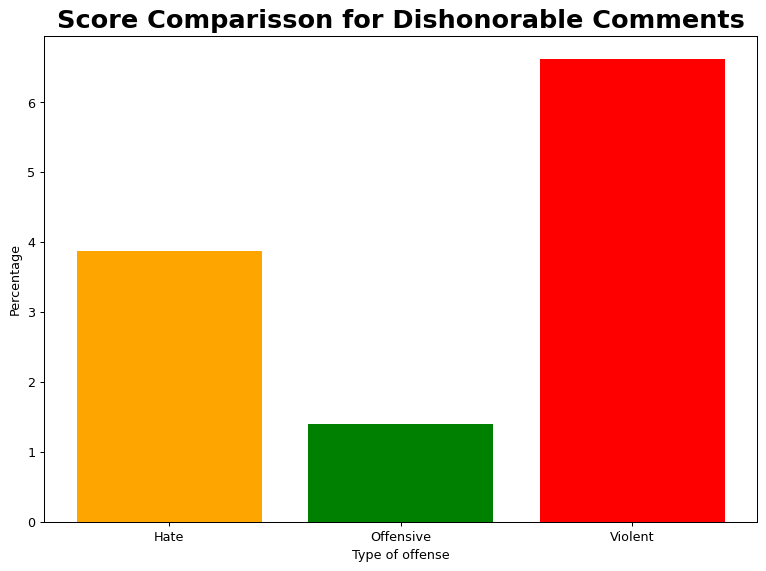

In [59]:
values = [percentage_total_hate, percentage_total_offensive, percentage_total_violent]

plt.figure(figsize=(10,7), dpi= 92)
plt.bar(['Hate', 'Offensive', 'Violent'], values, color=['orange', 'green', 'red'])
plt.title('Score Comparisson for Dishonorable Comments', fontsize=20, fontweight='bold')
plt.xlabel('Type of offense')
plt.ylabel('Percentage')
plt.show()

## Feature Extraction

In [40]:
# Create a new column to convert the title column from list to string

df['str_title'] = df['title'].astype(str)
df.dtypes

Name                           object
Comment                        object
Time                           object
Likes                         float64
Reply Count                   float64
cleaned_tweet                  object
title                          object
length                          int64
hate_score                      int64
hate_score_percentage         float64
offensive_score                 int64
offensive_score_percentage    float64
violent_score                   int64
str_title                      object
dtype: object

In [41]:
# For loop to extract features based on positive reviews

feature_extractions = dict()                                # Create a dictionary

for index, row in df.iterrows():                            # Iterate through each row for the positive comments column
    doc = nlp(row["str_title"])
    for token in doc:                                       # Iterate through each word within that row
        if token.text not in ("'", 'iranrevolution', 'iranprotests', 'iranrevoiution', 'freeiran', 'mahsaamini', 'mashaamini', 'iranians'):
            if token.pos_ == 'NOUN':                            # Get the nouns from the sentences
                if token.text in feature_extractions:           # Count the number of times the noun appears
                    feature_extractions[token.text] +=1
                else:
                    feature_extractions[token.text] = 1

# Sort the dictionary where the highest number of features are on the top, then show the top 10 features
feature_extractions_sorted = sorted(feature_extractions.items(), key = lambda x: x[1], reverse = True)
top_five_feature_extractions = feature_extractions_sorted[0:10]
top_five_feature_extractions

[('women', 3391),
 ('people', 3040),
 ('quot', 1592),
 ('world', 1215),
 ('freedom', 1169),
 ('regime', 1148),
 ('government', 1034),
 ('religion', 1015),
 ('police', 962),
 ('woman', 865)]

In [42]:
# View Full List
feature_extractions_sorted

[('women', 3391),
 ('people', 3040),
 ('quot', 1592),
 ('world', 1215),
 ('freedom', 1169),
 ('regime', 1148),
 ('government', 1034),
 ('religion', 1015),
 ('police', 962),
 ('woman', 865),
 ('country', 848),
 ('time', 716),
 ('href', 692),
 ('youtube', 654),
 ('rights', 585),
 ('life', 529),
 ('countries', 482),
 ('morality', 471),
 ('death', 469),
 ('http', 462),
 ('results', 450),
 ('search', 441),
 ('query', 440),
 ('power', 433),
 ('human', 429),
 ('years', 404),
 ('revolution', 403),
 ('https', 344),
 ('west', 325),
 ('evil', 311),
 ('protests', 311),
 ('peace', 309),
 ('news', 309),
 ('head', 295),
 ('protest', 292),
 ('support', 283),
 ('change', 277),
 ('family', 269),
 ('thing', 268),
 ('oppression', 267),
 ('girl', 257),
 ('hair', 251),
 ('wrong', 248),
 ('media', 243),
 ('protesters', 238),
 ('choice', 232),
 ('democracy', 229),
 ('things', 228),
 ('heart', 228),
 ('shame', 209),
 ('name', 201),
 ('state', 199),
 ('republic', 197),
 ('shah', 191),
 ('girls', 190),
 ('societ

## Clustering

In [60]:
# Performing clustering to find the number of natural clusters in the data

# Perform a natural clustering on the comments
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# create a list of all the comments
all_comments = list()
for comment in df['title']:
    all_comments.append(' '.join(comment))

# create a tfidf vectorizer object
vectorizer = TfidfVectorizer(stop_words='english')

# fit the vectorizer to the comments
X = vectorizer.fit_transform(all_comments)

# create a kmeans object
kmeans = KMeans(n_clusters=5, random_state=0)

# fit the kmeans object to the vectorizer
kmeans.fit(X)

# get the cluster labels
labels = kmeans.labels_

# add the cluster labels to the dataframe
df['cluster'] = labels
df.head(10)

,Name,Comment,Time,Likes,Reply Count,cleaned_tweet,title,length,hate_score,hate_score_percentage,offensive_score,offensive_score_percentage,violent_score,str_title,violent_score_percentage,cluster
0,Guardian News,Iranian schoolgirl ‘beaten to death for refusi...,2022-10-19T09:42:51Z,8.0,2.0,iranian schoolgirl beaten death refusing sing ...,"[iranian, schoolgirl, death, regime, anthem, h...",24,3,12.500000,0,0.000000,8,"['iranian', 'schoolgirl', 'death', 'regime', '...",33.333333,0
1,silent majority,One more reason why IS lam not compatible for...,2022-10-19T21:11:37Z,NaN,NaN,one reason lam compatible western democracy br...,"[more, reason, compatible, western, democracy,...",7,1,14.285714,1,14.285714,0,"['more', 'reason', 'compatible', 'western', 'd...",0.000000,0
2,Good,Free Iran,2022-10-22T22:05:44Z,0.0,0.0,free iran,"[free, iran]",2,0,0.000000,0,0.000000,0,"['free', 'iran']",0.000000,1
3,Spencer Brown,"This abhorrent, evil, archaic regime is killin...",2022-10-22T16:33:27Z,0.0,0.0,abhorrent evil archaic regime killing woman sc...,"[abhorrent, evil, archaic, regime, women, scarf]",6,0,0.000000,0,0.000000,1,"['abhorrent', 'evil', 'archaic', 'regime', 'wo...",16.666667,2
4,sunita thind,I have no words. Grateful to have freedoms 🇬🇧h...,2022-10-22T08:54:14Z,1.0,0.0,word grateful freedom many beautiful innocent ...,"[words, grateful, freedoms, many, beautiful, i...",7,0,0.000000,0,0.000000,0,"['words', 'grateful', 'freedoms', 'many', 'bea...",0.000000,2
5,Rajshekar Mudhigonda,What is the use of UN raising concern. Does it...,2022-10-22T06:47:00Z,0.0,0.0,use un raising concern going solve issue power...,"[what, concern, issue, power, power, legitimac...",14,0,0.000000,0,0.000000,3,"['what', 'concern', 'issue', 'power', 'power',...",21.428571,0
6,Atusa Atusaaa,Thank you for Support IRAN ❤️,2022-10-21T21:37:27Z,0.0,0.0,thank support iran,"[support, iran]",2,0,0.000000,0,0.000000,1,"['support', 'iran']",50.000000,1
7,X_X,Wipe out all protesters because the are only u...,2022-10-21T16:14:29Z,0.0,0.0,wipe protester using opposition fight govt lol...,"[protesters, opposition, govt, masha, group, g...",9,0,0.000000,0,0.000000,2,"['protesters', 'opposition', 'govt', 'masha', ...",22.222222,3
8,eda7491,Viva woman,2022-10-21T15:10:46Z,0.0,0.0,viva woman,[woman],1,0,0.000000,0,0.000000,0,['woman'],0.000000,0
9,shims,Iran to the world: Do NOT believe what is bein...,2022-10-21T15:05:42Z,1.0,0.0,iran world believe said medium bunch lie br sa...,"[iran, world, what, your, media, bunch, lies, ...",13,0,0.000000,0,0.000000,1,"['iran', 'world', 'what', 'your', 'media', 'bu...",7.692308,1


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


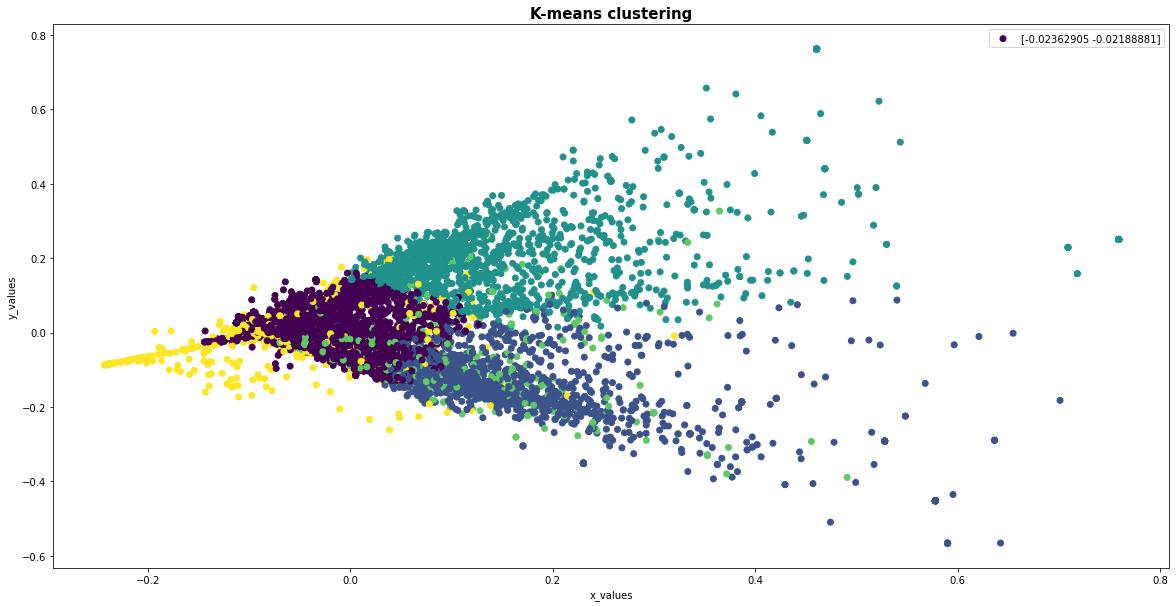

In [61]:
# Plot the clusters
from sklearn.decomposition import PCA

# create a pca object
pca = PCA(n_components=2)

# fit the pca object to the vectorizer
pca.fit(X.toarray())

# get the first two principal components
data2D = pca.transform(X.toarray())

# plot the clusters
plt.figure(figsize=(20,10))
plt.scatter(data2D[:,0], data2D[:,1], c=labels)
# Add legend, title and axis names
plt.legend(data2D)
plt.title('K-means clustering', fontsize=15, fontweight='bold')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.show()

In [62]:
# Check the top 10 words in each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(5):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print('\n')

Cluster 0:
 religion
 islam
 people
 hijab
 police
 world
 woman
 regime
 iranian
 good


Cluster 1:
 iran
 people
 freedom
 regime
 iranian
 free
 islamic
 world
 country
 time


Cluster 2:
 women
 iranian
 iran
 hijab
 freedom
 muslim
 brave
 rights
 world
 islam


Cluster 3:
 government
 iranian
 people
 iran
 religion
 country
 women
 freedom
 woman
 hijab


Cluster 4:
 quot
 query
 search
 http
 results
 youtube
 href
 mahsaamini
 mahsa
 iran




In [63]:
# Get 5 random comments from each cluster
for i in range(5):
    print("Cluster %d:" % i)
    for comment in df[df['cluster'] == i]['title'].sample(5):
        print(' '.join(comment))
    print('\n')

Cluster 0:
people power peace masha vain change this
heartbreaking things world
good hackers
secular philosophy something that cave what reality secular thinkers what insane
equality gender lets gender separation martial arts soccer wrestling


Cluster 1:
syed baqir sanctions iran
everyone their rights freedom
effinism iran
bright future people iran great their shameful theocracy knees chief enemy they iranian women time iran strength claws predatory americans affairs friend nobody ruling elites
country iran america israel anti iranians them iran long live khamenei live resistance


Cluster 2:
that true women moral police them
hijab time other rights iran muslim women other muslim women
this muslim society iran there plenty muslim women iran dress code role women society issue more power muslim women responsible lets specific there other issues which attention details blanket statement this your position
heartbreaking deaths iranian women morality strong your right freedom humans phili

## Clustering on hate score

In [64]:
df2 = df.dropna()

len(df), len(df2)

(14988, 10329)

In [69]:
y_predicted = kmeans.fit_predict(df2[['hate_score', 'offensive_score', 'violent_score', 'length']])

In [70]:
df2['predicted_cluster'] = y_predicted
df.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Name,Comment,Time,Likes,Reply Count,cleaned_tweet,title,length,hate_score,hate_score_percentage,offensive_score,offensive_score_percentage,violent_score,str_title,violent_score_percentage,cluster
0,Guardian News,Iranian schoolgirl ‘beaten to death for refusi...,2022-10-19T09:42:51Z,8.0,2.0,iranian schoolgirl beaten death refusing sing ...,"[iranian, schoolgirl, death, regime, anthem, h...",24,3,12.500000,0,0.000000,8,"['iranian', 'schoolgirl', 'death', 'regime', '...",33.333333,0
1,silent majority,One more reason why IS lam not compatible for...,2022-10-19T21:11:37Z,NaN,NaN,one reason lam compatible western democracy br...,"[more, reason, compatible, western, democracy,...",7,1,14.285714,1,14.285714,0,"['more', 'reason', 'compatible', 'western', 'd...",0.000000,0
2,Good,Free Iran,2022-10-22T22:05:44Z,0.0,0.0,free iran,"[free, iran]",2,0,0.000000,0,0.000000,0,"['free', 'iran']",0.000000,1
3,Spencer Brown,"This abhorrent, evil, archaic regime is killin...",2022-10-22T16:33:27Z,0.0,0.0,abhorrent evil archaic regime killing woman sc...,"[abhorrent, evil, archaic, regime, women, scarf]",6,0,0.000000,0,0.000000,1,"['abhorrent', 'evil', 'archaic', 'regime', 'wo...",16.666667,2
4,sunita thind,I have no words. Grateful to have freedoms 🇬🇧h...,2022-10-22T08:54:14Z,1.0,0.0,word grateful freedom many beautiful innocent ...,"[words, grateful, freedoms, many, beautiful, i...",7,0,0.000000,0,0.000000,0,"['words', 'grateful', 'freedoms', 'many', 'bea...",0.000000,2


In [72]:
df2[['hate_score', 'offensive_score', 'violent_score', 'length', 'predicted_cluster']]

,hate_score,offensive_score,violent_score,length,predicted_cluster
0,3,0,8,24,0
2,0,0,0,2,2
3,0,0,1,6,2
4,0,0,0,7,2
5,0,0,3,14,0
...,...,...,...,...,...
14953,0,0,0,3,2
14954,0,0,0,3,2
14959,0,0,0,1,2
14960,0,0,1,3,2


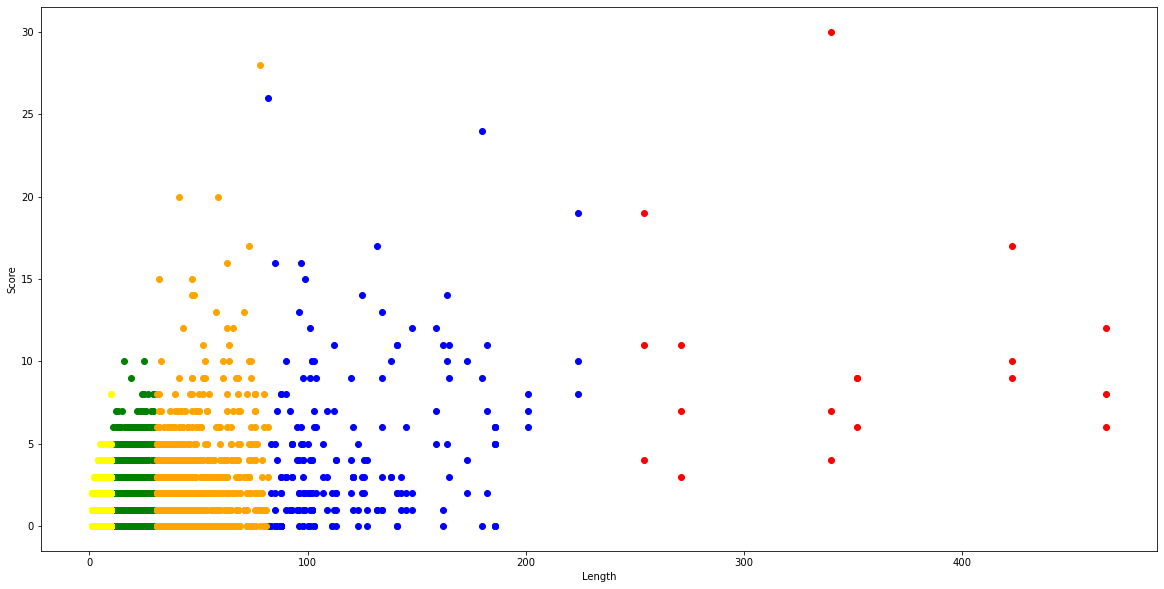

In [73]:
cl1 = df2[df2['predicted_cluster'] == 0]
cl2 = df2[df2['predicted_cluster'] == 1]
cl3 = df2[df2['predicted_cluster'] == 2]
cl4 = df2[df2['predicted_cluster'] == 3]
cl5 = df2[df2['predicted_cluster'] == 4]

plt.figure(figsize=(20,10))

plt.scatter(cl1['length'], cl1['hate_score'], color = 'green')
plt.scatter(cl2['length'], cl2['hate_score'], color = 'red')
plt.scatter(cl3['length'], cl3['hate_score'], color = 'yellow')
plt.scatter(cl4['length'], cl4['hate_score'], color = 'orange')
plt.scatter(cl5['length'], cl5['hate_score'], color = 'blue')

plt.scatter(cl1['length'], cl1['offensive_score'], color = 'green')
plt.scatter(cl2['length'], cl2['offensive_score'], color = 'red')
plt.scatter(cl3['length'], cl3['offensive_score'], color = 'yellow')
plt.scatter(cl4['length'], cl4['offensive_score'], color = 'orange')
plt.scatter(cl5['length'], cl5['offensive_score'], color = 'blue')

plt.scatter(cl1['length'], cl1['violent_score'], color = 'green')
plt.scatter(cl2['length'], cl2['violent_score'], color = 'red')
plt.scatter(cl3['length'], cl3['violent_score'], color = 'yellow')
plt.scatter(cl4['length'], cl4['violent_score'], color = 'orange')
plt.scatter(cl5['length'], cl5['violent_score'], color = 'blue')

plt.xlabel('Length')
plt.ylabel('Score')
plt.show()